## Extract generic and missing categories from SQL database

In [17]:
import sqlite3
import json
import os
import pandas as pd
import re
from IPython.display import display  # For Jupyter Notebook display

# SQLite database file path
DB_PATH = "../../data/pipeline2/sql/epd_database.sqlite"
OUTPUT_FILE_PATH = "../../data/pipeline2/sql/filtered_epd_data.csv"

# Allowed Classifications (normalized)
ALLOWED_CATEGORIES = {
    "construction products, infrastructure and buildings",
    "construction products",
    "N/A"  # Handling missing categories
}

# Synonym & Unit Normalization Dictionary
SYNONYM_DICT = {
    "kilogram": "kg",
    "kilograms": "kg",
    "gram": "g",
    "grams": "g",
    "liter": "L",
    "liters": "L",
    "metre": "m",
    "meter": "m",
    "centimetre": "cm",
    "centimeter": "cm",
    "millimetre": "mm",
    "millimeter": "mm"
}

def clean_text(text, lowercase=True):
    """Cleans and normalizes text: removes special characters, extra spaces, and normalizes synonyms & units."""
    if not isinstance(text, str):
        return "N/A"

    text = text.strip().replace("\n", " ")  # Remove newlines and trim spaces
    text = re.sub(r'\s+', ' ', text)  # Remove excessive spaces

    if lowercase:
        text = text.lower()  # Convert to lowercase for consistency
    
    # Normalize punctuation (replace "&" with "and")
    text = text.replace("&", "and")

    # Remove special characters (except spaces, common separators)
    text = re.sub(r'[^a-zA-Z0-9.,\-_/()\s]', '', text)

    # Normalize synonyms and units
    for key, value in SYNONYM_DICT.items():
        text = text.replace(key, value)

    return text

# Function to extract relevant fields from JSON
def extract_epd_data(json_data):
    """Extracts key fields from the EPD JSON document and applies preprocessing & filters."""
    try:
        process_info = json_data.get("processInformation", {})
        dataset_info = process_info.get("dataSetInformation", {})
        classification_info = dataset_info.get("classificationInformation", {}).get("classification", [])
        technology_info = process_info.get("technology", {})

        # Extract base name (product name)
        base_name = clean_text(dataset_info.get("name", {}).get("baseName", [{}])[0].get("value", "N/A"), lowercase=False)

        # Extract classification
        classification = "N/A"
        if classification_info:
            classification = clean_text(classification_info[0]["class"][0].get("value", "N/A"))

        # Debugging: Print all unique classifications to check raw values
        # print(f"DEBUG: Found classification -> {classification}")

        # Extract technology description (manufacturing process)
        technology_description = "N/A"
        if "technologyDescriptionAndIncludedProcesses" in technology_info:
            tech_desc_list = technology_info["technologyDescriptionAndIncludedProcesses"]
            if tech_desc_list:
                technology_description = clean_text(tech_desc_list[0].get("value", "N/A"), lowercase=False)

        # **Filtering Conditions**
        if classification in ALLOWED_CATEGORIES and technology_description != "N/A":
            return {
                "Product Name": base_name,
                "Classification": classification,
                "Technology Description": technology_description
            }
        else:
            return None  # Skip EPDs that don't meet the conditions

    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

# Connect to SQLite and retrieve JSON data
def fetch_epd_data():
    """Fetches and filters EPD data from SQLite."""
    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()

        # Fetch all rows from the table
        cursor.execute("SELECT document FROM epd_documents")
        rows = cursor.fetchall()

        extracted_data = []
        unique_classifications = set()

        for row in rows:
            try:
                json_data = json.loads(row[0])  # Parse JSON from SQLite
                epd_info = extract_epd_data(json_data)
                if epd_info:
                    extracted_data.append(epd_info)
                    unique_classifications.add(epd_info["Classification"])  # Store unique classifications for debugging
            except json.JSONDecodeError:
                print("Skipping invalid JSON record.")

        conn.close()

        # Print all unique classification values found
        print("\n### Unique Classifications Found ###")
        for cls in sorted(unique_classifications):
            print(f"- {cls}")

        # Convert extracted data into a DataFrame
        df = pd.DataFrame(extracted_data)

        return df

    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
        return None

# Run the extraction and display results
df_epd = fetch_epd_data()

# Check if the DataFrame is valid
if df_epd is not None and not df_epd.empty:
    display(df_epd)  # Show the data in Jupyter Notebook

    # Ensure the output directory exists
    output_dir = os.path.dirname(OUTPUT_FILE_PATH)
    os.makedirs(output_dir, exist_ok=True)

    # Save DataFrame to CSV
    try:
        df_epd.to_csv(OUTPUT_FILE_PATH, index=False, encoding="utf-8")
        print(f"Filtered EPD data saved to: {OUTPUT_FILE_PATH}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")

else:
    print("No matching EPDs found.")

Error extracting data: 'NoneType' object has no attribute 'get'

### Unique Classifications Found ###
- N/A
- construction products
- construction products, infrastructure and buildings


,Product Name,Classification,Technology Description
0,Durasein Solid Surface,"construction products, infrastructure and buil...",Durasein Solid Surface product Manufacturing p...
1,"beForce Rck50 S5 XC3 D20 CEM II 42,5 R CAM20","construction products, infrastructure and buil...","Concrete is produced by mixing cement, aggrega..."
2,Blended Hydraulic Cement,construction products,The product investigated in this EPD is Tabuk ...
3,"CEM II/B-LL 32,5 R - Sacchi - Colacem S.p.A. -...",construction products,"The cement CEM II/B-LL 32,5 R bagged cement wi..."
4,"CEM IV/A (P) 42,5 R - SR - RAGUSA CEMENTI S.p.A.",construction products,"The cement CEM IV/A (P) 42,5 R - SR respond an..."
...,...,...,...
8571,Polyisocyanurate Sandwich Panels (PIR) with Mu...,N/A,Listed below are the relevant technical charac...
8572,Polyisocyanurate Sandwich Panels (PIR) with Mu...,N/A,Listed below are the relevant technical charac...
8573,Polyisocyanurate Sandwich Panels (PIR) with Mu...,N/A,Listed below are the relevant technical charac...
8574,Polyisocyanurate Sandwich Panels (PIR) with Mu...,N/A,Listed below are the relevant technical charac...


Filtered EPD data saved to: ../../data/pipeline2/sql/filtered_epd_data.csv


## Iteration 2

In [27]:
import sqlite3
import json
import os
import pandas as pd
import re
from IPython.display import display  # For Jupyter Notebook display

# SQLite database file path
DB_PATH = "../../data/pipeline2/sql/epd_database.sqlite"
OUTPUT_FILE_PATH = "../../data/pipeline2/sql/filtered_epd_data_test.csv"

# Allowed Classifications (normalized)
ALLOWED_CATEGORIES = {
    "construction products, infrastructure and buildings",
    "construction products",
    "N/A"  # Handling missing categories
}

# Synonym & Unit Normalization Dictionary
SYNONYM_DICT = {
    "kilogram": "kg",
    "kilograms": "kg",
    "gram": "g",
    "grams": "g",
    "liter": "L",
    "liters": "L",
    "metre": "m",
    "meter": "m",
    "centimetre": "cm",
    "centimeter": "cm",
    "millimetre": "mm",
    "millimeter": "mm"
}

def clean_text(text, lowercase=True):
    """Cleans and normalizes text: removes newlines, extra spaces, normalizes punctuation, and standardizes synonyms/units."""
    if not isinstance(text, str):
        return "N/A"

    text = text.strip().replace("\n", " ")          # Remove newlines and trim spaces
    text = re.sub(r'\s+', ' ', text)                  # Remove excessive spaces
    if lowercase:
        text = text.lower()                           # Lowercase text if desired
    # Normalize punctuation (replace "&" with "and")
    text = text.replace("&", "and")
    # Remove special characters (except spaces and common separators)
    text = re.sub(r'[^a-zA-Z0-9.:,\-_/()\s]', '', text)
    # Normalize synonyms and units
    for key, value in SYNONYM_DICT.items():
        text = text.replace(key, value)
    return text

def extract_epd_data(json_data):
    """Extracts key fields from the EPD JSON document, including additional fields."""
    try:
        process_info = json_data.get("processInformation", {})
        dataset_info = process_info.get("dataSetInformation", {})
        classification_info = dataset_info.get("classificationInformation", {}).get("classification", [])
        geography_info = process_info.get("geography", {}).get("locationOfOperationSupplyOrProduction", {})
        technology_info = process_info.get("technology", {})
        modelling_info = json_data.get("modellingAndValidation", {})
        exchanges_info = json_data.get("exchanges", {})

        # Extract key fields
        uuid = dataset_info.get("UUID", "N/A")
        base_name = clean_text(dataset_info.get("name", {}).get("baseName", [{}])[0].get("value", "N/A"), lowercase=False)
        classification = "N/A"
        if classification_info:
            classification = clean_text(classification_info[0]["class"][0].get("value", "N/A"))
        geographic_location = geography_info.get("location", "N/A")
        technology_description = "N/A"
        if "technologyDescriptionAndIncludedProcesses" in technology_info:
            tech_desc_list = technology_info["technologyDescriptionAndIncludedProcesses"]
            if tech_desc_list:
                technology_description = clean_text(tech_desc_list[0].get("value", "N/A"), lowercase=False)
        technological_applicability = "N/A"
        if "technologicalApplicability" in technology_info:
            tech_applicability_list = technology_info["technologicalApplicability"]
            if tech_applicability_list and isinstance(tech_applicability_list, list) and len(tech_applicability_list) > 0:
                technological_applicability = clean_text(tech_applicability_list[0].get("value", "N/A"), lowercase=False)
        lca_method_details = "N/A"
        lci_method_allocation = modelling_info.get("LCIMethodAndAllocation", {})
        ref_to_lca_method_details = lci_method_allocation.get("referenceToLCAMethodDetails", [])
        if ref_to_lca_method_details and isinstance(ref_to_lca_method_details, list) and len(ref_to_lca_method_details) > 0:
            short_desc_list = ref_to_lca_method_details[0].get("shortDescription", [])
            if short_desc_list and isinstance(short_desc_list, list) and len(short_desc_list) > 0:
                lca_method_details = clean_text(short_desc_list[0].get("value", "N/A"), lowercase=False)
        flow_dataset_short_desc = "N/A"
        exchanges = exchanges_info.get("exchange", [])
        if exchanges and isinstance(exchanges, list) and len(exchanges) > 0:
            ref_to_flow_dataset = exchanges[0].get("referenceToFlowDataSet", {})
            short_desc_list = ref_to_flow_dataset.get("shortDescription", [])
            if short_desc_list and isinstance(short_desc_list, list) and len(short_desc_list) > 0:
                flow_dataset_short_desc = clean_text(short_desc_list[0].get("value", "N/A"), lowercase=False)
        flow_property_name = "N/A"
        if exchanges and isinstance(exchanges, list) and len(exchanges) > 0:
            flow_properties = exchanges[0].get("flowProperties", [])
            if flow_properties and isinstance(flow_properties, list) and len(flow_properties) > 0:
                name_list = flow_properties[0].get("name", [])
                if name_list and isinstance(name_list, list) and len(name_list) > 0:
                    flow_property_name = clean_text(name_list[0].get("value", "N/A"), lowercase=False)
        flow_property_mean_value = "N/A"
        if exchanges and isinstance(exchanges, list) and len(exchanges) > 0:
            flow_properties = exchanges[0].get("flowProperties", [])
            if flow_properties and isinstance(flow_properties, list) and len(flow_properties) > 0:
                flow_property_mean_value = flow_properties[0].get("meanValue", "N/A")
        flow_property_reference_unit = "N/A"
        if exchanges and isinstance(exchanges, list) and len(exchanges) > 0:
            flow_properties = exchanges[0].get("flowProperties", [])
            if flow_properties and isinstance(flow_properties, list) and len(flow_properties) > 0:
                flow_property_reference_unit = flow_properties[0].get("referenceUnit", "N/A")
        
        # Filter the data based on allowed classifications.
        if classification in ALLOWED_CATEGORIES:
            return {
                "Product Name": base_name,
                "Technology Description": technology_description,
                "Classification": classification,
                "Technological Applicability": technological_applicability,
                "LCA Method Details": lca_method_details,
                "Flow Dataset Short Description": flow_dataset_short_desc,
                "Flow Property Name": flow_property_name,
                "Flow Property Mean Value": flow_property_mean_value,
                "Flow Property Reference Unit": flow_property_reference_unit,
                "Geographic Location": geographic_location,
                "UUID": uuid,
            }
        else:
            return None

    except Exception as e:
        print(f"Error extracting data: {e}")
        return None

def fetch_epd_data():
    """Fetches and filters EPD data from SQLite."""
    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()

        # Fetch all rows from the table
        cursor.execute("SELECT document FROM epd_documents")
        rows = cursor.fetchall()

        extracted_data = []
        unique_classifications = set()

        for row in rows:
            try:
                json_data = json.loads(row[0])
                epd_info = extract_epd_data(json_data)
                if epd_info:
                    extracted_data.append(epd_info)
                    unique_classifications.add(epd_info["Classification"])
            except json.JSONDecodeError:
                print("Skipping invalid JSON record.")

        conn.close()

        print("\n### Unique Classifications Found ###")
        for cls in sorted(unique_classifications):
            print(f"- {cls}")

        df = pd.DataFrame(extracted_data)
        return df

    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
        return None

# Run extraction and display results.
df_epd = fetch_epd_data()

if df_epd is not None and not df_epd.empty:
    display(df_epd)
    output_dir = os.path.dirname(OUTPUT_FILE_PATH)
    os.makedirs(output_dir, exist_ok=True)
    try:
        df_epd.to_csv(OUTPUT_FILE_PATH, index=False, encoding="utf-8")
        print(f"Filtered EPD data saved to: {OUTPUT_FILE_PATH}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")
else:
    print("No matching EPDs found.")


Error extracting data: 'NoneType' object has no attribute 'get'

### Unique Classifications Found ###
- N/A


,Product Name,Technology Description,Classification,Technological Applicability,LCA Method Details,Flow Dataset Short Description,Flow Property Name,Flow Property Mean Value,Flow Property Reference Unit,Geographic Location,UUID
0,"CLASSIC 037, Expert IPR 037, KI FIT 037, NATUR...",.,N/A,.,2019:14-c-PCR-005 Thermal Insulation products,Non-renewable material resources / Glass miner...,Area,1.0,m2,DE,F51FE930-34C6-452F-B83D-3430B53579E3
1,EPD-IES-0002133:003 (S-P-02133) Mape-Antique D...,N/A,N/A,N/A,Construction products (EN 15804A2),MAPE-ANTIQUE RINZAFFO,Mass,1.0,kg,GLO,760915ef-ec5e-42a4-b593-0e16dd4eae6e
2,EPD-IES-0002232:001 (S-P-02232) Aluminium Foil,N/A,N/A,N/A,Construction products (EN 15804A2),Aluminium Foil,Mass,1.0,kg,GLO,f4a06ce3-d6c9-44b6-8da0-1090a4250c53
3,EPD-IES-0002565:001 PPG Sigma Woodprotect Soli...,N/A,N/A,N/A,Construction products (EN 15804A2),1 kg of PPG Sigma Woodprotect Solid Satin,Mass,1.0,kg,RER,116c869d-f421-48a4-123d-08dc90830688
4,EPD-IES-0002788:001 PPG GORI Professional Adva...,N/A,N/A,N/A,Construction products (EN 15804A2),1 kg of PPG GORI Professional Advance DKK,Mass,1.0,kg,RER,0ddc9534-3627-41e5-1242-08dc90830688
...,...,...,...,...,...,...,...,...,...,...,...
5251,Velux Modular Skylight (triple glazing configu...,N/A,N/A,N/A,N/A,Velux Modular Skylight (triple glazing configu...,Carbon content (biogenic) - packaging,1.0,N/A,DK,46368cb1-7451-4bda-92a6-4c63963d4e3b
5252,Veveo AC Top Clean,N/A,N/A,N/A,N/A,Veveo AC Top Clean,N/A,N/A,N/A,N/A,a5a3e868-4854-47a8-939d-a6b0e1d519ae
5253,Vigilant Low Profile Linear LED Light,N/A,N/A,N/A,N/A,Vigilant Low Profile Linear LED Light,N/A,N/A,N/A,GB,5639f414-d7df-4d78-b919-6d4aa50f70b3
5254,Welded Masonry Support System,N/A,N/A,N/A,N/A,Welded Masonry Support System,N/A,N/A,N/A,GB,ed9ebad5-9765-4155-bb12-f8a5cf8c6c4b


Filtered EPD data saved to: ../../data/pipeline2/sql_filtered_csv/filtered_epd_data_test.csv


In [19]:
import pandas as pd
import os

# File path
file_path = "../../data/pipeline2/sql/filtered_epd_data_test.csv"

# Check if file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read CSV file
    df_epd = pd.read_csv(file_path)

    # **STEP 1: Clean Text Fields to Remove Extra Spaces & Special Characters**
    def clean_text(text):
        """Ensure uniform text formatting by removing extra spaces and special characters."""
        if isinstance(text, str):
            text = text.strip()  # Remove leading/trailing spaces
            text = text.replace("\n", " ")  # Replace newlines with spaces
            text = " ".join(text.split())  # Remove excessive spaces
            return text
        return "N/A"

    df_epd = df_epd.map(clean_text)  # Apply cleaning to all text fields

    # **STEP 2: Force Left Alignment for ALL Content**
    def left_align_column(column, width):
        """Ensure consistent left alignment by padding each entry to a fixed width."""
        return column.astype(str).str.ljust(width)

    # Define dynamic column widths based on max length in each column
    col_widths = {col: max(df_epd[col].astype(str).apply(len).max(), len(col)) + 2 for col in df_epd.columns}

    # Apply left-alignment formatting to each column
    for col, width in col_widths.items():
        df_epd[col] = left_align_column(df_epd[col], width)

    # **STEP 3: Print Properly Aligned Table**
    print(df_epd.head(20).to_string(index=False))


                                                                                                                                                                                                                                                                                                 Product Name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Check Category Distribuition

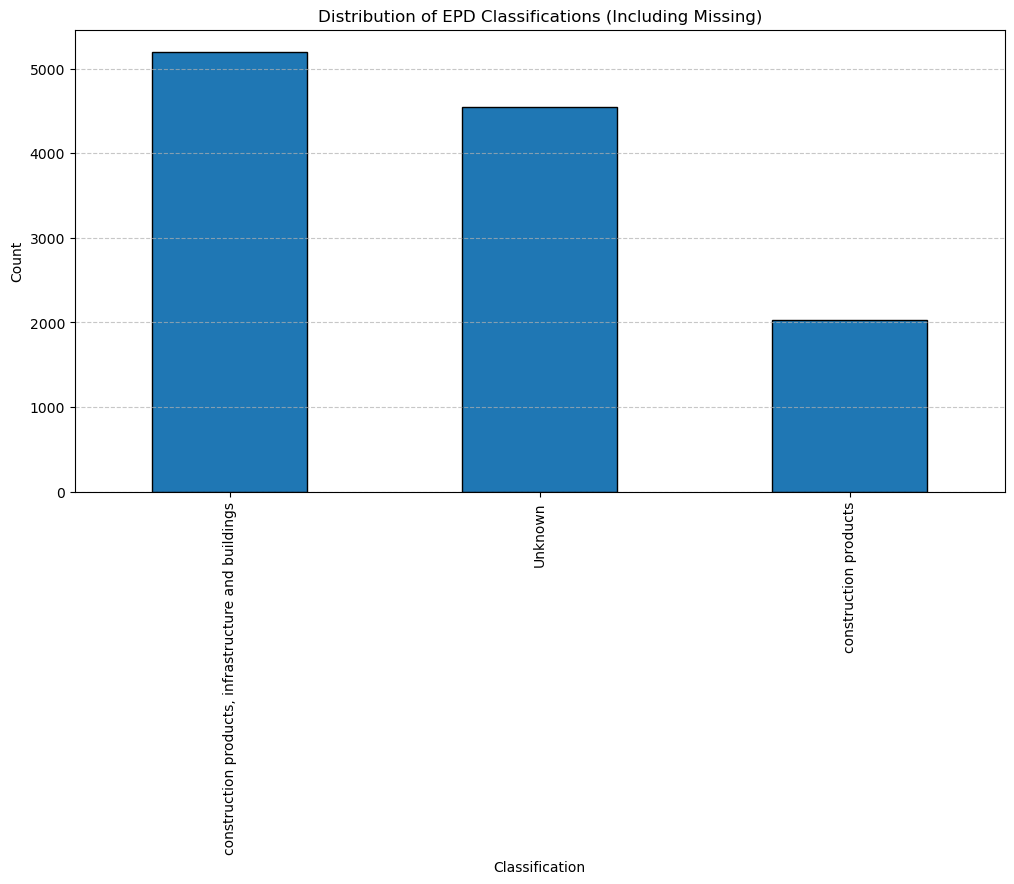


### Classification Counts ###
construction products, infrastructure and buildings: 5199
Unknown: 4551
construction products: 2025


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define file path
file_path = "../../data/pipeline2/sql/filtered_epd_data02.csv"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read the CSV file
    df_epd = pd.read_csv(file_path)

    # Replace missing values in the Classification column with "Unknown"
    df_epd["Classification"] = df_epd["Classification"].fillna("Unknown")

    # Get classification counts
    classification_counts = df_epd["Classification"].value_counts()

    # Plot the classification distribution
    plt.figure(figsize=(12, 6))
    classification_counts.plot(kind="bar", edgecolor="black")

    # Formatting the plot
    plt.xlabel("Classification")
    plt.ylabel("Count")
    plt.title("Distribution of EPD Classifications (Including Missing)")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()

    # Print classification counts in text format
    print("\n### Classification Counts ###")
    for classification, count in classification_counts.items():
        print(f"{classification}: {count}")


## Check Character and Token Counts of `technologyDescriptionAndIncludedProcesses`

Mean character count: 524.71
Median character count: 337.00
Standard deviation (chars): 557.61
25th, 50th, 75th, 90th, 95th percentiles (chars): [ 170.  337.  696. 1125. 1465.]
IQR (chars): 526.00

Mean token count: 107.99
Median token count: 70.00
Standard deviation (tokens): 113.85
25th, 50th, 75th, 90th, 95th percentiles (tokens): [ 36.   70.  142.  223.  291.5]
IQR (tokens): 106.00



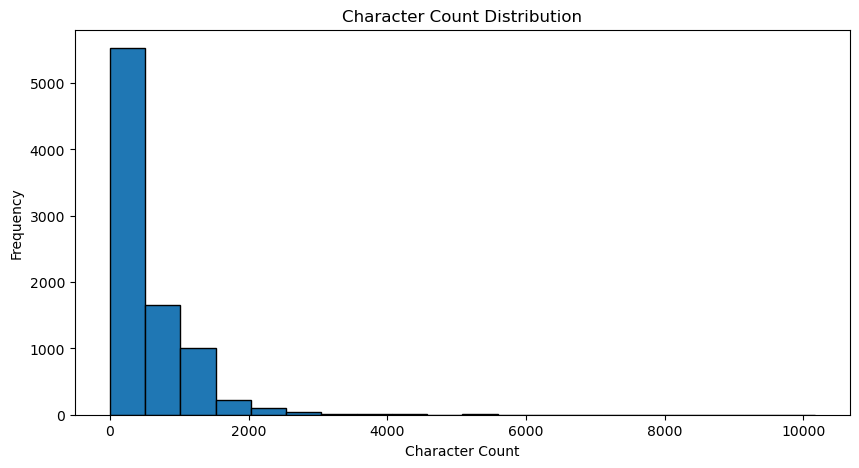

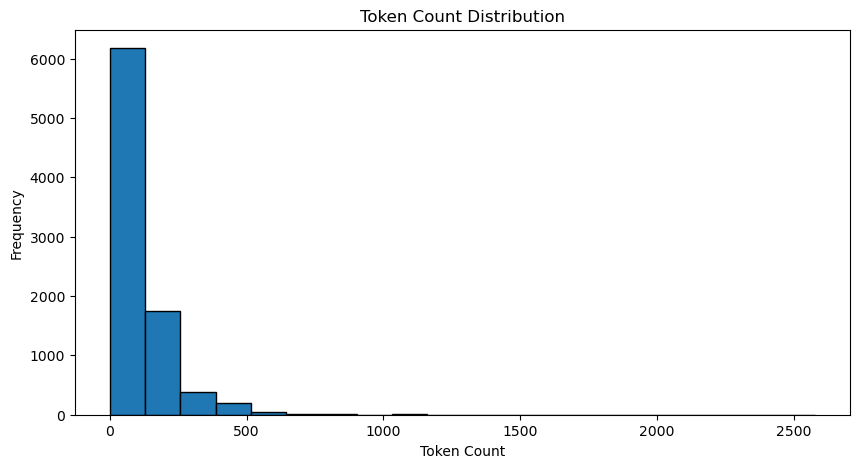

Character Count Histogram Data
  1.0 - 509.1: 5529
509.1 - 1017.2: 1660
1017.2 - 1525.3: 1004
1525.3 - 2033.4: 217
2033.4 - 2541.5: 100
2541.5 - 3049.6: 40
3049.6 - 3557.7: 12
3557.7 - 4065.8: 12
4065.8 - 4573.9: 7
4573.9 - 5082.0: 1
5082.0 - 5590.1: 4
5590.1 - 6098.2: 1
6098.2 - 6606.3: 2
6606.3 - 7114.4: 1
7114.4 - 7622.5: 0
7622.5 - 8130.6: 0
8130.6 - 8638.7: 0
8638.7 - 9146.8: 0
9146.8 - 9654.9: 0
9654.9 - 10163.0: 1
Token Count Histogram Data
  1.0 - 129.8: 6176
129.8 - 258.5: 1743
258.5 - 387.2: 383
387.2 - 516.0: 201
516.0 - 644.8: 52
644.8 - 773.5: 13
773.5 - 902.2: 12
902.2 - 1031.0: 1
1031.0 - 1159.8: 6
1159.8 - 1288.5: 2
1288.5 - 1417.2: 1
1417.2 - 1546.0: 0
1546.0 - 1674.8: 0
1674.8 - 1803.5: 0
1803.5 - 1932.2: 0
1932.2 - 2061.0: 0
2061.0 - 2189.8: 0
2189.8 - 2318.5: 0
2318.5 - 2447.2: 0
2447.2 - 2576.0: 1


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
import statistics
import os

# File path for the processed EPD data
file_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read the CSV file
    df_epd = pd.read_csv(file_path)

    # Combine relevant text columns into a single string per row
    df_epd["tech_descr"] = df_epd[["Technology Description"]].astype(str).agg(" ".join, axis=1)

    # Compute character and token counts
    lengths = df_epd["tech_descr"].apply(len).tolist()

    # Initialize tokenizer
    enc = tiktoken.get_encoding("o200k_base")
    token_counts = [len(enc.encode(text)) for text in df_epd["tech_descr"]]

    # Basic statistics
    mean_length = statistics.mean(lengths) if lengths else 0
    mean_tokens = statistics.mean(token_counts) if token_counts else 0

    median_length = np.median(lengths) if lengths else 0
    median_tokens = np.median(token_counts) if token_counts else 0

    std_length = np.std(lengths, ddof=1) if len(lengths) > 1 else 0
    std_tokens = np.std(token_counts, ddof=1) if len(token_counts) > 1 else 0

    percentiles_length = np.percentile(lengths, [25, 50, 75, 90, 95]) if lengths else [0] * 5
    percentiles_tokens = np.percentile(token_counts, [25, 50, 75, 90, 95]) if token_counts else [0] * 5

    iqr_length = percentiles_length[2] - percentiles_length[0]
    iqr_tokens = percentiles_tokens[2] - percentiles_tokens[0]

    # Print statistical measures
    print(f"Mean character count: {mean_length:.2f}")
    print(f"Median character count: {median_length:.2f}")
    print(f"Standard deviation (chars): {std_length:.2f}")
    print(f"25th, 50th, 75th, 90th, 95th percentiles (chars): {percentiles_length}")
    print(f"IQR (chars): {iqr_length:.2f}\n")

    print(f"Mean token count: {mean_tokens:.2f}")
    print(f"Median token count: {median_tokens:.2f}")
    print(f"Standard deviation (tokens): {std_tokens:.2f}")
    print(f"25th, 50th, 75th, 90th, 95th percentiles (tokens): {percentiles_tokens}")
    print(f"IQR (tokens): {iqr_tokens:.2f}\n")

    # Plot histograms for visual inspection
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=20, edgecolor="black")
    plt.title("Character Count Distribution")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(token_counts, bins=20, edgecolor="black")
    plt.title("Token Count Distribution")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.show()

    # Print histogram data in numeric format
    def print_histogram_data(data, bins=20, title="Histogram"):
        counts, bin_edges = np.histogram(data, bins=bins)
        print(title)
        for i in range(len(counts)):
            lower = bin_edges[i]
            upper = bin_edges[i + 1]
            print(f"{lower:5.1f} - {upper:5.1f}: {counts[i]}")

    print_histogram_data(lengths, bins=20, title="Character Count Histogram Data")
    print_histogram_data(token_counts, bins=20, title="Token Count Histogram Data")


## Summarize `technologyDescriptionAndIncludedProcesses`

In [ ]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response.
json_schema = {
    "title": "SummarizationResponse",
    "description": "Response containing a summarized version of the technology description.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description emphasizing key raw materials and its use in construction."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that only uses the Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in summarizing technical manufacturing processes for building material products.
Summarize the following technology description into a concise paragraph that emphasizes:
- The key raw materials (e.g., PMMA, titanium dioxide, aluminum hydroxide, etc.)
Avoid excessive process details; focus on the material composition and intended use.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (adjust as needed for your environment)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b"
model = ChatOllama(model=llm_model)

def summarize_technology_description(text):
    """Uses Ollama to summarize a long Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
summaries = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(tech_description)
        # Create a dictionary for this row, including a row index for reference.
        summaries.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Summary for row {idx}:\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{number_entries}_technology_summaries.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=2)

print(f"All summaries saved to {output_file}")


Summary for row 0:
The manufacturing process involves mixing titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (PMMA) to create a solid surface product. The process includes steps such as pouring, curing, cutting, grinding, cleaning, inspection, and packaging. The raw materials are primarily used in construction.
--------------------------------------------------

Summary for row 1:
Concrete is produced by mixing cement, aggregates (sand, crushed stone), water, and additives. The process involves storage silos for cement, loading via augers into truck mixers with dust control systems, unloading of coarse aggregates from supplier trucks using hoppers and belts, dosing additives with volumetric dosers and mixing water with electromechanical systems. The mixture is then homogenized in a concrete mixer barrel powered by electricity, and the final product is shipped via special truck mixers for use in construction.
--------------------------------------------------

Summary 

### Iteration 2

In [15]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response.
json_schema = {
    "title": "SummarizationResponse",
    "description": "Response containing a summarized version of the technology description.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description emphasizing key raw materials and its use in construction."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that only uses the Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in summarizing technical documents of building material products to facilitate categorization.
Summarize the following technology description into a concise paragraph emphasizing key raw materials and its use in construction.
If no materials are mentioned, avoid excessive process details.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (adjust as needed for your environment)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b"
model = ChatOllama(model=llm_model)

def summarize_technology_description(text):
    """Uses Ollama to summarize a long Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
summaries = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(tech_description)
        # Create a dictionary for this row, including a row index for reference.
        summaries.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Summary for row {idx}:\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{number_entries}_tech_sum_one_paragraph.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=2)

print(f"All summaries saved to {output_file}")


Summary for row 0:
Durasein Solid Surface product is manufactured using titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (PMMA) as primary raw materials. The process involves mixing, pouring, curing, cutting, grinding, cleaning, inspection, and packaging. Waste corrugated cardboard is incinerated, and PET film is disposed of in a sanitary landfill based on assumptions from an EPD report.
--------------------------------------------------

Summary for row 1:
Concrete is made by mixing cement, aggregates (sand, crushed stone, gravel), water, and additives. These components are mixed using concrete mixers. The process involves storage silos for cement, loading with augers, dust abatement systems, unloading of coarse aggregates via belt conveyors, dosing of additives and water using volumetric and electromechanical dosers, and mixing in a concrete mixer barrel. The energy is provided by electricity, and the final product is shipped using special truck mixers, complying wit

## Extract Composition Materials from `technologyDescriptionAndIncludedProcesses`

In [1]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the composition extraction response.
json_schema = {
    "title": "CompositionExtractionResponse",
    "description": "Response containing a list of key composition materials extracted from the technology description.",
    "type": "object",
    "properties": {
        "composition": {
            "type": "string",
            "description": "A list of key raw materials mentioned in the technology description, e.g., PMMA, titanium dioxide, aluminum hydroxide."
        }
    },
    "required": ["composition"]
}

# Create a prompt template that focuses on extracting composition materials from the Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in technical manufacturing processes for building material products.
Extract and list the key composition materials from the following technology description. 
Focus exclusively on the raw materials (e.g., PMMA, titanium dioxide, aluminum hydroxide, etc.) used in the product.
Avoid including unnecessary process details; only list the materials.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (adjust as needed for your environment)
llm_model = "deepseek-r1:8b"  # for example, "deepseek-r1:8b"
model = ChatOllama(model=llm_model)

def extract_composition_materials(text):
    """Uses Ollama to extract the composition materials from a Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "composition" in structured_response:
        return structured_response["composition"]
    return None

# Path to the CSV file.
csv_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
composition_extractions = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        composition = extract_composition_materials(tech_description)
        # Create a dictionary for this row, including a row index for reference.
        composition_extractions.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Extracted Composition": composition
        })
        print(f"Extracted composition for row {idx}:\n{composition}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.\n{'-'*50}\n")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{number_entries}_technology_compositions.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(composition_extractions, f, indent=2)

print(f"All composition extractions saved to {output_file}")

Extracted composition for row 0:
titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (pmma)
--------------------------------------------------

Extracted composition for row 1:
cement, aggregates (sand, crushed stone, gravel), water, additives
--------------------------------------------------

Extracted composition for row 2:
limestone, pozzolona, schist, gypsum, iron oxide
--------------------------------------------------

Extracted composition for row 3:
marl, limestone, gypsum
--------------------------------------------------

Extracted composition for row 4:
limestone, clay, gypsum, pozzolan
--------------------------------------------------

Extracted composition for row 5:
limestone, clay, gypsum, pozzolan
--------------------------------------------------

Extracted composition for row 6:
diisocyanate, polyol, plasticizer, catalysts, colorant, foaming agents
--------------------------------------------------

Extracted composition for row 7:
cement, aggregates (

## Do Both Summarization and Composition Material Extraction from `technologyDescriptionAndIncludedProcesses`

In [5]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the combined summarization and composition extraction response.
json_schema = {
    "title": "SummarizationAndCompositionResponse",
    "description": "Response containing a summarized version of the technology description and a list of key composition materials.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description emphasizing key raw materials and its use in construction."
        },
        "composition": {
            "type": "string",
            "description": "A list of key raw materials mentioned in the technology description, e.g., PMMA, titanium dioxide, aluminum hydroxide."
        }
    },
    "required": ["summary", "composition"]
}

# Create a prompt template that instructs the model to provide both outputs.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in technical manufacturing processes for building material products.
Given the following technology description, perform two tasks:
1. Summarize the description into a concise paragraph that emphasizes the key raw materials.
2. Extract and list the key composition materials mentioned (e.g., PMMA, titanium dioxide, aluminum hydroxide).

Avoid excessive process details; focus on material composition and intended use.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (this is dynamic so you can test different models)
llm_model = "deepseek-r1:8b"  # For example, "deepseek-r1:8b", "falcon3:7b-instruct-q4_K_M",
model = ChatOllama(model=llm_model)

def process_technology_description(text):
    """Uses Ollama to get both a summary and the extracted composition materials from a Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()

    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response and "composition" in structured_response:
        return structured_response
    return {"summary": None, "composition": None}

# Path to the CSV file.
csv_path = os.path.join("..", "..", "data", "pipeline2", "sql", "filtered_epd_data.csv")

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
results = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        response = process_technology_description(tech_description)
        results.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": response.get("summary"),
            "Extracted Composition": response.get("composition")
        })
        print(f"Summary and material composition for row {idx}:\n{response.get("summary")}\n{response.get("composition")}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)

# Include the model name in the output file name.
model_name = llm_model.split(":")[0]
output_file = os.path.join(output_dir, f"{number_entries}_technology_summary_composition_{model_name}.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print(f"All responses saved to {output_file}")


Summary and material composition for row 0:
The process involves manufacturing a solid surface product using titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (PMMA). These materials are mixed, poured, cured, cut, ground, cleaned, inspected, and packaged. The process also includes waste management through incineration of corrugated cardboard and PET film, with the remaining waste sent to a sanitary landfill.
titanium dioxide, aluminum hydroxide, polymethyl methacrylate (PMMA)
--------------------------------------------------

Summary and material composition for row 1:
Concrete is produced by mixing cement, aggregates (sand, crushed stone, and gravel), water, and additives. The process includes dosing of additives and water using volumetric dosers and electromechanical systems, conveying materials into a mixer barrel for homogenization and mixing, with the final product being delivered via special truck mixers. The concrete complies with specific regulations.
cement, s

## Summarize starting with Product Name

In [10]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response (only a summary field).
json_schema = {
    "title": "TechnologySummaryResponse",
    "description": "Response containing a concise technology summary that begins with the product name.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description that starts with the product name."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that uses both the Product Name and Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in technical manufacturing processes for building material products.
Using the information provided, produce a concise technology summary that begins with the product name.
The summary should start with "The product {product_name}" and then describe the manufacturing process and key raw materials.

Technology Description: {text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (this can be changed dynamically)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b" or another model name
model = ChatOllama(model=llm_model)

def summarize_technology_description(product_name, text):
    """Uses Ollama to generate a summary for the technology description that starts with the product name."""
    final_prompt = prompt_template.format_prompt(
        product_name=product_name,
        text=text,
        json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = os.path.join("..", "..", "data", "pipeline2", "sql", "filtered_epd_data.csv")
number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
results = []

# Process each row.
for idx, row in df.iterrows():
    product_name = row.get("Product Name", "")
    tech_description = row.get("Technology Description", "")
    if product_name and tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(product_name, tech_description)
        results.append({
            "row_index": idx,
            "Product Name": product_name,
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Processed row {idx}\n{product_name}\n\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} missing product name or technology description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)

# Include the model name in the output file name.
model_name = llm_model.split(":")[0]
output_file = os.path.join(output_dir, f"{number_entries}_tech_sum_prodname_{model_name}.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print(f"All summaries saved to {output_file}")

Processed row 0
Durasein Solid Surface

The product Durasein Solid Surface is manufactured through a process involving mixing, pouring, curing, cutting, grinding, cleaning, inspection, and packaging. The key raw materials include titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (PMMA). Waste materials generated during the process are corrugated cardboard, pet film, and sanitary landfill waste. These are incinerated to manage environmental impact.
--------------------------------------------------

Processed row 1
beForce Rck50 S5 XC3 D20 CEM II 42,5 R CAM20

The product beForce Rck50 S5 XC3 D20 CEM II 42,5 R CAM20 is a concrete production system utilizing advanced manufacturing techniques. It involves mixing cement, aggregates (sand, crushed stone, and gravel), water, and additives in a controlled environment to ensure consistent quality. The process includes the storage of cement in silos connected to a weighbridge for precise measurement. Cement is then loaded into t

### Iteration 2

In [11]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response (only a summary field).
json_schema = {
    "title": "TechnologySummaryResponse",
    "description": "Response containing a concise technology summary that begins with the product name.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description that starts with the product name."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that uses both the Product Name and Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in technical manufacturing processes for building material products.
Using the information provided, produce a one sentence summary that begins with the product name.
The summary should start with "The product {product_name}" and then describe concisely the product.

Technology Description: {text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (this can be changed dynamically)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b" or another model name
model = ChatOllama(model=llm_model)

def summarize_technology_description(product_name, text):
    """Uses Ollama to generate a summary for the technology description that starts with the product name."""
    final_prompt = prompt_template.format_prompt(
        product_name=product_name,
        text=text,
        json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = os.path.join("..", "..", "data", "pipeline2", "sql", "filtered_epd_data.csv")
number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
results = []

# Process each row.
for idx, row in df.iterrows():
    product_name = row.get("Product Name", "")
    tech_description = row.get("Technology Description", "")
    if product_name and tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(product_name, tech_description)
        results.append({
            "row_index": idx,
            "Product Name": product_name,
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Processed row {idx}\n{product_name}\n\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} missing product name or technology description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)

# Include the model name in the output file name.
model_name = llm_model.split(":")[0]
output_file = os.path.join(output_dir, f"{number_entries}_tech_sum_prodname_{model_name}.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print(f"All summaries saved to {output_file}")

Processed row 0
Durasein Solid Surface

The product Durasein Solid Surface is manufactured through a process involving mixing, pouring, curing, cutting, grinding, cleaning, inspection, and packaging raw materials including titanium dioxide, aluminum hydroxide, and polymethyl methacrylate (PMMA), with waste corrugated cardboard incinerated, PET film disposed of in sanitary landfill.
--------------------------------------------------

Processed row 1
beForce Rck50 S5 XC3 D20 CEM II 42,5 R CAM20

The product beForce Rck50 S5 XC3 D20 CEM II 42,5 R CAM20 is a concrete mixing equipment designed for efficient and precise production of high-quality concrete.
--------------------------------------------------

Processed row 2
Blended Hydraulic Cement

The product Blended Hydraulic Cement is an environmentally friendly material produced by mixing ordinary cement clinker, gypsum, and a high percentage of pozzolona (30%), resulting in a composition rich in limestone, pozzolona, schist, gypsum, and

## Summarize Technology Descriptions in one Sentence

In [3]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response.
json_schema = {
    "title": "SummarizationResponse",
    "description": "Response containing a summarized version of the technology description.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description emphasizing key raw materials and its use in construction."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that only uses the Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in summarizing technical documents of building material products.
Summarize the following technology description into a concise sentence that facilitates the categorization of the building product.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (adjust as needed for your environment)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b"
model = ChatOllama(model=llm_model)

def summarize_technology_description(text):
    """Uses Ollama to summarize a long Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
summaries = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(tech_description)
        # Create a dictionary for this row, including a row index for reference.
        summaries.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Summary for row {idx}:\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{number_entries}_tech_sum_one_sentence.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=2)

print(f"All summaries saved to {output_file}")


Summary for row 0:
The manufacturing process for a durable surface product involves mixing, pouring, curing, cutting, grinding, cleaning, inspection, and packaging. It uses titanium dioxide, aluminum hydroxide, and polymethyl methacrylate as raw materials, with waste materials including corrugated cardboard, pet film, and sanitary landfill, based on the EPD report.
--------------------------------------------------

Summary for row 1:
Concrete is manufactured by combining cement, sand, gravel, water, and additives through a mixing process powered by electricity, used extensively in building and construction.
--------------------------------------------------

Summary for row 2:
The product is Tabuk Cement Company's green cement, made from a blend including 30% Pozzolona, and other ingredients such as limestone, gypsum, schist, and iron oxide.
--------------------------------------------------

Summary for row 3:
The cement CEM II/B-LL 32,5 R bagged cement produced by Colacem S.p.A. at 

### Iteration 2

In [14]:
import json
import os
import pandas as pd
from langchain_ollama import ChatOllama  # Use your Ollama integration
from langchain_core.prompts import ChatPromptTemplate

# Define a JSON schema for the summarization response.
json_schema = {
    "title": "SummarizationResponse",
    "description": "Response containing a summarized version of the technology description.",
    "type": "object",
    "properties": {
        "summary": {
            "type": "string",
            "description": "A concise summary of the technology description emphasizing key raw materials and its use in construction."
        }
    },
    "required": ["summary"]
}

# Create a prompt template that only uses the Technology Description.
prompt_template = ChatPromptTemplate.from_template(
    """
You are an expert in summarizing technical documents of building material products to facilitate categorization.
Summarize the following technology description into a concise sentence emphasizing key raw materials and its use in construction.

Technology Description:
{text}

Return your answer in JSON format following this schema:
{json_schema}
"""
)

# Set your Ollama model name (adjust as needed for your environment)
llm_model = "deepseek-r1:8b"  # e.g., "deepseek-r1:8b"
model = ChatOllama(model=llm_model)

def summarize_technology_description(text):
    """Uses Ollama to summarize a long Technology Description."""
    final_prompt = prompt_template.format_prompt(
        text=text, json_schema=json.dumps(json_schema)
    ).to_string()
    
    structured_llm = model.with_structured_output(
        json_schema, method="json_schema", include_raw=True
    )
    raw_response = structured_llm.invoke(final_prompt)
    structured_response = raw_response.get("parsed", None)
    if structured_response and "summary" in structured_response:
        return structured_response["summary"]
    return None

# Path to the CSV file.
csv_path = "../../data/pipeline2/sql/filtered_epd_data.csv"

number_entries = 100

# Read the CSV file and select only the first 100 entries.
df = pd.read_csv(csv_path).head(number_entries)

# Container to hold all responses.
summaries = []

# Process each row.
for idx, row in df.iterrows():
    tech_description = row.get("Technology Description", "")
    if tech_description and isinstance(tech_description, str):
        summary = summarize_technology_description(tech_description)
        # Create a dictionary for this row, including a row index for reference.
        summaries.append({
            "row_index": idx,
            "Product Name": row.get("Product Name", ""),
            "Classification": row.get("Classification", ""),
            "Technology Description Summary": summary
        })
        print(f"Summary for row {idx}:\n{summary}\n{'-'*50}\n")
    else:
        print(f"Row {idx} has no Technology Description.")

# Ensure the output directory exists.
output_dir = os.path.join("..", "..", "data", "pipeline2", "json")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"{number_entries}_tech_sum_one_sentence02.json")

# Write the JSON responses to file.
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=2)

print(f"All summaries saved to {output_file}")


Summary for row 0:
The Durasein Solid Surface product is manufactured using titanium dioxide, aluminum hydroxide, and polymethyl methacrylate as raw materials, with the process involving mixing, pouring, curing, cutting, grinding, cleaning, inspection, and packaging. Waste corrugated cardboard is incinerated, while PET film is sent to a sanitary landfill as part of the manufacturing process.
--------------------------------------------------

Summary for row 1:
Concrete is made by mixing cement, sand, crushed stone, water, and additives. These components are combined using specialized equipment, including mixers and conveyors, to produce concrete for construction applications.
--------------------------------------------------

Summary for row 2:
The Tabuk Cement Company's green cement, produced using 30% natural pozzolona, a high percentage of limestone, gypsum, schist, and iron oxide, is a blended hydraulic cement used in construction.
------------------------------------------------

## Print Character and Token Count

Mean character count: 332.09
Median character count: 320.50
Standard deviation (chars): 102.13
25th, 50th, 75th, 90th, 95th percentiles (chars): [246.75 320.5  417.75 455.   497.55]
IQR (chars): 171.00

Mean token count: 63.29
Median token count: 61.50
Standard deviation (tokens): 19.93
25th, 50th, 75th, 90th, 95th percentiles (tokens): [48.   61.5  75.25 85.2  99.2 ]
IQR (tokens): 27.25



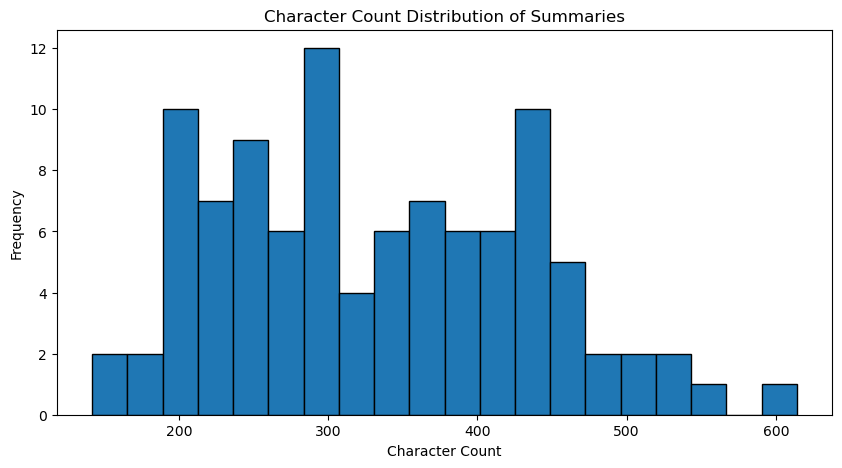

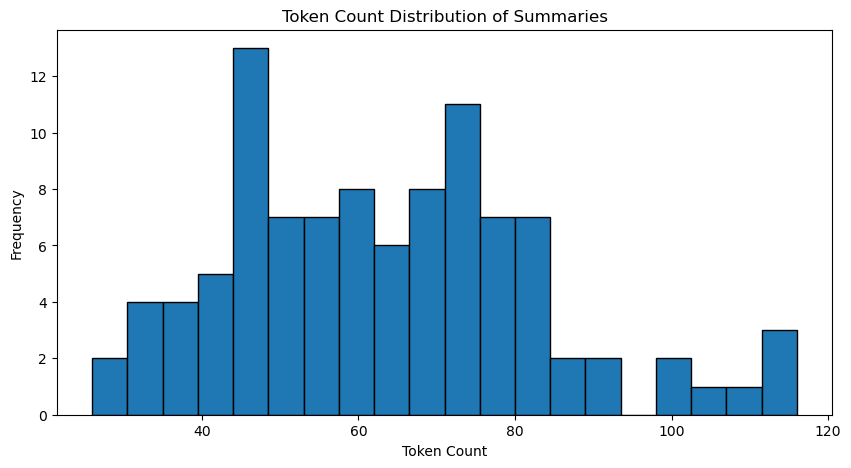

Character Count Histogram Data
142.0 - 165.6: 2
165.6 - 189.2: 2
189.2 - 212.8: 10
212.8 - 236.4: 7
236.4 - 260.0: 9
260.0 - 283.6: 6
283.6 - 307.2: 12
307.2 - 330.8: 4
330.8 - 354.4: 6
354.4 - 378.0: 7
378.0 - 401.6: 6
401.6 - 425.2: 6
425.2 - 448.8: 10
448.8 - 472.4: 5
472.4 - 496.0: 2
496.0 - 519.6: 2
519.6 - 543.2: 2
543.2 - 566.8: 1
566.8 - 590.4: 0
590.4 - 614.0: 1
Token Count Histogram Data
 26.0 -  30.5: 2
 30.5 -  35.0: 4
 35.0 -  39.5: 4
 39.5 -  44.0: 5
 44.0 -  48.5: 13
 48.5 -  53.0: 7
 53.0 -  57.5: 7
 57.5 -  62.0: 8
 62.0 -  66.5: 6
 66.5 -  71.0: 8
 71.0 -  75.5: 11
 75.5 -  80.0: 7
 80.0 -  84.5: 7
 84.5 -  89.0: 2
 89.0 -  93.5: 2
 93.5 -  98.0: 0
 98.0 - 102.5: 2
102.5 - 107.0: 1
107.0 - 111.5: 1
111.5 - 116.0: 3


In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
import statistics
import os

# File path for the JSON summaries
json_file_path = os.path.join("..", "..", "data", "pipeline2", "json", "100_technology_summaries.json")

# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    # Load JSON data
    with open(json_file_path, "r", encoding="utf-8") as f:
        summaries = json.load(f)
    
    # Convert JSON list to a DataFrame
    df = pd.DataFrame(summaries)
    
    # We assume that the summarized text is under the key "Technology Description Summary"
    # If your key is different (e.g., "summary"), adjust accordingly.
    if "Technology Description Summary" not in df.columns:
        print("Key 'Technology Description Summary' not found in JSON data.")
    else:
        # Compute the character count of each summary.
        df["char_count"] = df["Technology Description Summary"].astype(str).apply(len)
        
        # Initialize the tokenizer.
        enc = tiktoken.get_encoding("o200k_base")
        df["token_count"] = df["Technology Description Summary"].astype(str).apply(lambda text: len(enc.encode(text)))
        
        # Collect counts into lists.
        lengths = df["char_count"].tolist()
        token_counts = df["token_count"].tolist()
        
        # Calculate basic statistics.
        mean_length = statistics.mean(lengths) if lengths else 0
        mean_tokens = statistics.mean(token_counts) if token_counts else 0
        median_length = np.median(lengths) if lengths else 0
        median_tokens = np.median(token_counts) if token_counts else 0
        std_length = np.std(lengths, ddof=1) if len(lengths) > 1 else 0
        std_tokens = np.std(token_counts, ddof=1) if len(token_counts) > 1 else 0
        percentiles_length = np.percentile(lengths, [25, 50, 75, 90, 95]) if lengths else [0] * 5
        percentiles_tokens = np.percentile(token_counts, [25, 50, 75, 90, 95]) if token_counts else [0] * 5
        iqr_length = percentiles_length[2] - percentiles_length[0]
        iqr_tokens = percentiles_tokens[2] - percentiles_tokens[0]
        
        # Print statistical measures.
        print(f"Mean character count: {mean_length:.2f}")
        print(f"Median character count: {median_length:.2f}")
        print(f"Standard deviation (chars): {std_length:.2f}")
        print(f"25th, 50th, 75th, 90th, 95th percentiles (chars): {percentiles_length}")
        print(f"IQR (chars): {iqr_length:.2f}\n")
        
        print(f"Mean token count: {mean_tokens:.2f}")
        print(f"Median token count: {median_tokens:.2f}")
        print(f"Standard deviation (tokens): {std_tokens:.2f}")
        print(f"25th, 50th, 75th, 90th, 95th percentiles (tokens): {percentiles_tokens}")
        print(f"IQR (tokens): {iqr_tokens:.2f}\n")
        
        # Plot histogram for character counts.
        plt.figure(figsize=(10, 5))
        plt.hist(lengths, bins=20, edgecolor="black")
        plt.title("Character Count Distribution of Summaries")
        plt.xlabel("Character Count")
        plt.ylabel("Frequency")
        plt.show()
        
        # Plot histogram for token counts.
        plt.figure(figsize=(10, 5))
        plt.hist(token_counts, bins=20, edgecolor="black")
        plt.title("Token Count Distribution of Summaries")
        plt.xlabel("Token Count")
        plt.ylabel("Frequency")
        plt.show()
        
        # Function to print histogram data numerically.
        def print_histogram_data(data, bins=20, title="Histogram"):
            counts, bin_edges = np.histogram(data, bins=bins)
            print(title)
            for i in range(len(counts)):
                lower = bin_edges[i]
                upper = bin_edges[i + 1]
                print(f"{lower:5.1f} - {upper:5.1f}: {counts[i]}")
        
        print_histogram_data(lengths, bins=20, title="Character Count Histogram Data")
        print_histogram_data(token_counts, bins=20, title="Token Count Histogram Data")


# Categories

In [6]:
import requests
import xml.etree.ElementTree as ET
from urllib.parse import quote

# Base URL for the API endpoints
BASE_URL = "https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/"

def get_categories(path):
    """
    Fetches categories from the API.
    - If path is empty, gets top-level categories.
    - Otherwise, retrieves subcategories for the given path.
    """
    if path:
        # Encode each segment in the path to handle spaces and special characters
        encoded_path = "/".join(quote(segment) for segment in path.split("/"))
        url = f"{BASE_URL}{encoded_path}/subcategories/?catSystem=oekobau.dat&lang=en&sort=id"
    else:
        url = f"{BASE_URL}?catSystem=oekobau.dat&lang=en&sort=id"
    
    # Debug print: Show the URL being requested
    print(f"Fetching URL: {url}")
    
    response = requests.get(url)
    response.raise_for_status()  # Stop if the request fails
    return ET.fromstring(response.content)

def build_tree(path, xml_parent, level=0):
    """
    Recursively builds the XML tree:
    - 'path' is used to construct the API URL.
    - 'xml_parent' is the XML element to which child categories will be added.
    - 'level' indicates the depth for debugging purposes.
    """
    indent = "  " * level
    print(f"{indent}Processing path: '{path or 'Top-level'}'")
    
    try:
        root = get_categories(path)
    except Exception as e:
        print(f"{indent}Error retrieving categories for path '{path}': {e}")
        return

    # Define namespace for parsing API XML
    ns = {"sapi": "http://www.ilcd-network.org/ILCD/ServiceAPI"}
    # Find all category elements regardless of their level
    for cat in root.findall(".//sapi:category", ns):
        cat_name = cat.text.strip() if cat.text else "Unknown"
        cat_id = cat.get("classId", "N/A")
        print(f"{indent}  Found category: {cat_name} (ID: {cat_id})")
        
        # Create a new XML element in our output with attributes id and name
        new_elem = ET.SubElement(xml_parent, "category", id=cat_id, name=cat_name)
        # Construct new path for recursion
        new_path = cat_name if not path else f"{path}/{cat_name}"
        # Recursively build tree for subcategories
        build_tree(new_path, new_elem, level + 1)

def main():
    # Register namespaces for the output file
    ET.register_namespace("", "http://lca.jrc.it/ILCD/Categories")
    ET.register_namespace("common", "http://lca.jrc.it/ILCD/Common")
    ET.register_namespace("xsi", "http://www.w3.org/2001/XMLSchema-instance")
    
    # Create the root element <CategorySystem> with attribute name="OEKOBAU.DAT"
    root_elem = ET.Element("CategorySystem", {"name": "OEKOBAU.DAT"})
    # Create the <categories> container with dataType="Process"
    categories_elem = ET.SubElement(root_elem, "categories", {"dataType": "Process"})
    
    print("Starting category tree traversal...")
    # Start building the tree from the top-level (empty path)
    build_tree("", categories_elem)
    
    # Write the constructed XML tree to a file with an XML declaration
    tree = ET.ElementTree(root_elem)
    output_file = "categories.xml"
    tree.write(output_file, encoding="UTF-8", xml_declaration=True)
    print(f"Finished. Categories saved to {output_file}")

if __name__ == "__main__":
    main()


Starting category tree traversal...
Processing path: 'Top-level'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/?catSystem=oekobau.dat&lang=en&sort=id
  Found category: Mineral building products (ID: 1)
  Processing path: 'Mineral building products'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineral%20building%20products/subcategories/?catSystem=oekobau.dat&lang=en&sort=id
    Found category: Binder (ID: 1.1)
    Processing path: 'Mineral building products/Binder'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineral%20building%20products/Binder/subcategories/?catSystem=oekobau.dat&lang=en&sort=id
      Found category: Cement (ID: 1.1.01)
      Processing path: 'Mineral building products/Binder/Cement'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineral%20building%20products/Binder/Cement/subcategories/?catSystem=oekobau.dat&lang=en&sort=id

In [7]:
import xml.dom.minidom

# Read the existing XML file
with open("categories.xml", "rb") as f:
    xml_data = f.read()

# Parse the XML using minidom
dom = xml.dom.minidom.parseString(xml_data)

# Pretty print the XML with desired indentation
pretty_xml = dom.toprettyxml(indent="    ", encoding="UTF-8")

# Write the prettified XML to a new file
with open("categories_pretty.xml", "wb") as f:
    f.write(pretty_xml)

print("Prettified XML saved to categories_pretty.xml")


Prettified XML saved to categories_pretty.xml


In [8]:
import requests
import xml.etree.ElementTree as ET
from urllib.parse import quote
import xml.dom.minidom

# Optimize to not go past level 2
# Problems getting all German categories because of umlauts in the URL 

# Base URL for the API endpoints
BASE_URL = "https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/"

def get_categories(path):
    """
    Fetches categories from the API.
    - If path is empty, gets top-level categories.
    - Otherwise, retrieves subcategories for the given path.
    """
    if path:
        encoded_path = "/".join(quote(segment) for segment in path.split("/"))
        url = f"{BASE_URL}{encoded_path}/subcategories/?catSystem=oekobau.dat&lang=en&sort=id"
    else:
        url = f"{BASE_URL}?catSystem=oekobau.dat&lang=en&sort=id"
    
    print(f"Fetching URL: {url}")
    response = requests.get(url)
    response.raise_for_status()  # Raise error for bad responses
    return ET.fromstring(response.content)

def build_tree(path, xml_parent, level=0):
    """
    Recursively builds the XML tree:
    - 'path' is used to construct the API URL.
    - 'xml_parent' is the XML element to which child categories will be added.
    - 'level' indicates the recursion depth (for debugging).
    """
    indent = "  " * level
    print(f"{indent}Processing path: '{path or 'Top-level'}'")
    
    try:
        root = get_categories(path)
    except Exception as e:
        print(f"{indent}Error retrieving categories for path '{path}': {e}")
        return

    ns = {"sapi": "http://www.ilcd-network.org/ILCD/ServiceAPI"}
    for cat in root.findall(".//sapi:category", ns):
        cat_name = cat.text.strip() if cat.text else "Unknown"
        cat_id = cat.get("classId", "N/A")
        print(f"{indent}  Found category: {cat_name} (ID: {cat_id})")
        
        new_elem = ET.SubElement(xml_parent, "category", id=cat_id, name=cat_name)
        new_path = cat_name if not path else f"{path}/{cat_name}"
        build_tree(new_path, new_elem, level + 1)

def main():
    # Register namespaces for the output file
    ET.register_namespace("", "http://lca.jrc.it/ILCD/Categories")
    ET.register_namespace("common", "http://lca.jrc.it/ILCD/Common")
    ET.register_namespace("xsi", "http://www.w3.org/2001/XMLSchema-instance")
    
    # Create the root element <CategorySystem> with attribute name="OEKOBAU.DAT"
    root_elem = ET.Element("CategorySystem", {"name": "OEKOBAU.DAT"})
    # Create the <categories> container with dataType="Process"
    categories_elem = ET.SubElement(root_elem, "categories", {"dataType": "Process"})
    
    print("Starting category tree traversal...")
    build_tree("", categories_elem)
    
    # Convert the ElementTree to a string and pretty print it using minidom
    xml_str = ET.tostring(root_elem, encoding="utf-8")
    parsed = xml.dom.minidom.parseString(xml_str)
    pretty_xml_str = parsed.toprettyxml(indent="    ", encoding="UTF-8")
    
    # Write the pretty XML to file
    with open("categories_en_pretty.xml", "wb") as f:
        f.write(pretty_xml_str)
    
    print("Finished. Categories saved to categories.xml")

if __name__ == "__main__":
    main()


Starting category tree traversal...
Processing path: 'Top-level'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/?catSystem=oekobau.dat&lang=de&sort=id
  Found category: Mineralische Baustoffe (ID: 1)
  Processing path: 'Mineralische Baustoffe'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineralische%20Baustoffe/subcategories/?catSystem=oekobau.dat&lang=de&sort=id
    Found category: Bindemittel (ID: 1.1)
    Processing path: 'Mineralische Baustoffe/Bindemittel'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineralische%20Baustoffe/Bindemittel/subcategories/?catSystem=oekobau.dat&lang=de&sort=id
      Found category: Zement (ID: 1.1.01)
      Processing path: 'Mineralische Baustoffe/Bindemittel/Zement'
Fetching URL: https://www.oekobaudat.de/OEKOBAU.DAT/resource/processes/categories/Mineralische%20Baustoffe/Bindemittel/Zement/subcategories/?catSystem=oekobau.dat&lang=de&sort=id
 